# Hands-on introduction to ML training
In this notebook we will tackle a different kind of problem: Classification

In this lesson, we will also learn use one-hot encoding, something we learnt about in the previous lesson.

### Step 1: Load and explore data
The first step is figuring out the data source. In this case we will use a pre-existing dataset. We will:
1. Create a folder 'data'
2. Download the file from public github repo using python package "requests" and save the titanic.csv file in the data folder.

In [ ]:
%config IPCompleter.greedy=True #Helps with auto-complete

import numpy as np
import pandas as pd
import os

try:
    os.mkdir('data')
except OSError as error:
    print(error)

import requests, csv

url = 'https://raw.githubusercontent.com/techno-nerd/ML_Course/main/04%20Classification/data/titanic.csv'
r = requests.get(url)
with open('data/titanic.csv', 'w') as f:
  writer = csv.writer(f)
  for line in r.iter_lines():
    writer.writerow(line.decode('utf-8').split(','))

In [1]:
df = pd.read_csv('data/titanic.csv')

In [2]:
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(df['Survived'].value_counts())
#0 = Died, 1 = Survived

Survived
0    549
1    342
Name: count, dtype: int64


### Visualising the distribution of rows for some of the features

<Axes: >

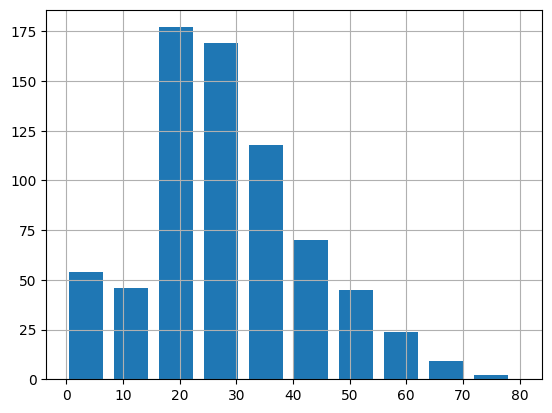

In [4]:
df['Age'].hist(width=6)

<Axes: xlabel='Pclass'>

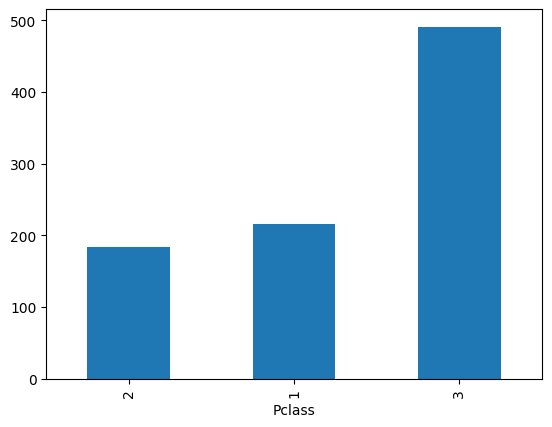

In [5]:
df['Pclass'].value_counts().sort_values().plot(kind='bar')

### Now, we are looking at the distribution of people who survived across a few different features to determine their importance

In [6]:
def survival_stats(variable):
    Died = df[df["Survived"]==0][variable].value_counts()
    Survived = df[df["Survived"]==1][variable].value_counts()

    data = pd.DataFrame([Died, Survived])
    data.index=["No", "Yes"]
    return data.head()

In [7]:
survival_stats('Sex')

Sex,male,female
No,468,81
Yes,109,233


In [8]:
survival_stats('Embarked')

Embarked,S,C,Q
No,427,75,47
Yes,217,93,30


### Step 2: Data preparation

There aere a few tasks we need to do before we can train the model on this data:
1. Replace string values like 'male' and 'female' with integers (0 and 1)
2. Handle categorical values for Embarked
3. Get rid of null values
4. Drop unnecessary columns like Name 
Then, we will split the data the same way as last time:
1. Split the data (181 rows) into training set (80%) and test set (20%)
2. Separate the input features ("GPA") from target variable ("SAT Score")

In [9]:
df['Sex'].replace({'male':1, 'female':0}, inplace=True)

In [10]:
print(df['Sex'].value_counts())

Sex
1    577
0    314
Name: count, dtype: int64


In [11]:
#Missing values
print(f"Total Passengers: {df.shape[0]}")
for i in df.columns:
    print(f"{i}: {sum(df[i].isnull())}")

Total Passengers: 891
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2


In [12]:
#Deleting all rows with missing values (except cabin, as that column will be removed)
df.dropna(subset=['Age', 'Embarked'], inplace=True)
print(df.shape[0])

712


In [13]:
print(df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [14]:
#All non-numeric features need to be ignored (embarked and class will be concatenated later after being one-hot encoded)

features = df[['Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
features[:5]

,Sex,Age,SibSp,Parch,Fare
0,1,22.0,1,0,7.2500
1,0,38.0,1,0,71.2833
2,0,26.0,0,0,7.9250
3,0,35.0,1,0,53.1000
4,1,35.0,0,0,8.0500


In [15]:
#One_hot encoding Passenger class
one_hot_class = pd.get_dummies(df['Pclass'])
features = features.join(one_hot_class)

print(df[:2])
features[:2]


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   

      Ticket     Fare Cabin Embarked  
0  A/5 21171   7.2500   NaN        S  
1   PC 17599  71.2833   C85        C  


,Sex,Age,SibSp,Parch,Fare,1,2,3
0,1,22.0,1,0,7.2500,False,False,True
1,0,38.0,1,0,71.2833,True,False,False


In [16]:
#One_hot encoding Embarked point
one_hot_embark = pd.get_dummies(df['Embarked'])
features = features.join(one_hot_embark)

print(df[:2])
features[:2]


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   

      Ticket     Fare Cabin Embarked  
0  A/5 21171   7.2500   NaN        S  
1   PC 17599  71.2833   C85        C  


,Sex,Age,SibSp,Parch,Fare,1,2,3,C,Q,S
0,1,22.0,1,0,7.2500,False,False,True,False,False,True
1,0,38.0,1,0,71.2833,True,False,False,True,False,False


In [17]:
print(features.dtypes)

Sex        int64
Age      float64
SibSp      int64
Parch      int64
Fare     float64
1           bool
2           bool
3           bool
C           bool
Q           bool
S           bool
dtype: object


In [18]:
for colName in features.columns:
    if features[colName].dtype == bool:
        print(colName)
        features[colName].replace({False:0, True:1}, inplace=True)

1
2
3
C
Q
S


In [19]:
print(features.dtypes)

Sex        int64
Age      float64
SibSp      int64
Parch      int64
Fare     float64
1          int64
2          int64
3          int64
C          int64
Q          int64
S          int64
dtype: object


In [20]:
features.columns = features.columns.astype(str)
print(features.columns)

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', '1', '2', '3', 'C', 'Q', 'S'], dtype='object')


In [22]:
import sklearn.model_selection as ms

labels = df['Survived']

train_features, test_features, train_labels, test_labels = ms.train_test_split(features, labels, test_size=0.2)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(569, 11)
(143, 11)
(569,)
(143,)


### Step 3: Model Selection and Training

For this problem, we will use a model called logistic regression.

This model also learns weights for each feature, just like a linear regression model. But,  it applies a function at the end that maps the value between 0 and 1.

In [23]:
from sklearn import linear_model as lm

logistic_mod = lm.LogisticRegression(solver='lbfgs', max_iter=500)
logistic_mod.fit(train_features, train_labels)

print(logistic_mod.coef_)
print(logistic_mod.intercept_)

[[-2.39696976 -0.04038807 -0.33919178 -0.00832263  0.0036029   1.02968285
  -0.0190924  -0.99847799  0.19717295 -0.25517268  0.07011219]]
[2.46787478]


In [24]:
train_probs = logistic_mod.predict_proba(train_features)
test_probs = logistic_mod.predict_proba(test_features)

In [25]:
print('Class 0 (Died) and Class 1 (Survived) probabilities')
print(train_probs[:5])

Class 0 (Died) and Class 1 (Survived) probabilities
[[0.17006342 0.82993658]
 [0.3946149  0.6053851 ]
 [0.16848274 0.83151726]
 [0.18075154 0.81924846]
 [0.88169603 0.11830397]]


### Step 4: Model evaluation and tuning
Unlike linear regression, we are not going to use Root Mean Squared Error. Instead, we will use three metrics:
1. Accuracy = total correct / total predictions
2. Precision = correct class 1 / total predicted class 1
3. Recall = correct class 1 / total number of class 1's


In [26]:
#Here, we are saying that whenever the confidence is above 50%, take it to be that value. This is called the threshold.

train_pred = np.where(train_probs[:, 1] > 0.5, 1, 0)
test_pred = np.where(test_probs[:, 1] > 0.5, 1, 0)

In [27]:
def ClassifierMetrics(labels, predictions):
    total = labels.size
    result = (labels == predictions)
    correct = result.sum()
    accuracy = (correct)/total

    #Precision (correct '1' prediction / total '1' prediction)
    precision = (result[predictions == 1.0].sum()) / (predictions == 1.0).sum()

    #Recall = (correct '1' predictions / total number of '1's)

    recall = (result[predictions == 1.0].sum()) / (labels == 1.0).sum()

    return [accuracy, precision, recall]

In [28]:
train_metrics = ClassifierMetrics(train_labels, train_pred)
print("TRAIN Metrics:")
print(f"Accuracy: {train_metrics[0]}")
print(f"Precision: {train_metrics[1]}")
print(f"Recall: {train_metrics[2]}")

Accuracy: 0.8014059753954306
Precision: 0.7836538461538461
Recall: 0.7056277056277056


In [29]:
test_metrics = ClassifierMetrics(test_labels, test_pred)
print("TEST Metrics:")
print(f"Accuracy: {test_metrics[0]}")
print(f"Precision: {test_metrics[1]}")
print(f"Recall: {test_metrics[2]}")

Accuracy: 0.7762237762237763
Precision: 0.7049180327868853
Recall: 0.7543859649122807
